In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
def rcparams(r=1):
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.size'] = 25 * r
    matplotlib.rcParams['xtick.labelsize'] = 20 * r
    matplotlib.rcParams['ytick.labelsize'] = 20 * r
    matplotlib.rcParams['axes.labelsize'] = 25 * r
    matplotlib.rcParams['legend.title_fontsize'] = 17 * r
    matplotlib.rcParams['legend.fontsize'] = 17 * r
    matplotlib.rcParams['axes.axisbelow'] = True
    matplotlib.rcParams['figure.figsize'] = [6 * r, 6 * r]


# format axis
def format_axis(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
        
def format_axis_im(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=0)
#     ax.locator_params(axis='x', nbins=5)
#     ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.base import clone

In [3]:
# #############################################################################
# Setting up


def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [4]:
# Models we will use
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

In [5]:
# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.14s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.83, time = 0.13s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.62, time = 0.14s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.88, time = 0.13s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.83, time = 0.13s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.56, time = 0.13s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.27, time = 0.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.17, time = 0.13s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

In [6]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.95      0.93       184
           2       0.94      0.95      0.94       166
           3       0.93      0.89      0.91       194
           4       0.95      0.95      0.95       186
           5       0.95      0.91      0.93       181
           6       0.98      0.96      0.97       207
           7       0.94      0.98      0.96       154
           8       0.89      0.90      0.89       182
           9       0.87      0.91      0.89       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       174
           1       0.60      0.58      0.59  

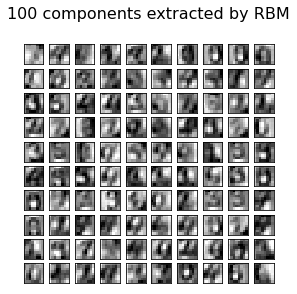

In [7]:
# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()